In [1]:
import pennylane as qml
from pennylane import numpy as np
import qemzmsepcV2new as qem

In [2]:
# we introduced noise into the network and trained it without any error mitigation techniques
# to observe the behavior of the Loss function degradation during training.
n_qubits = 2
dev = qml.device('default.mixed', wires=n_qubits, shots=1000)
nqubitschannel = qem.NqubitsChannel(n_qubits)
nqubitspaulichannel = nqubitschannel.nqubitsrandompaulichannel(p_identity=0.85)
p = 0.9
qemzmsepc = qem.QEMZMSEPC(n_qubits)

In [3]:
def train_cir_without_qem(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(2))

def cost(x):
    e = qml.QNode(qemzmsepc.noise_circuit, dev)(train_cir_without_qem, x, p=p,
            kraus_matrices_of_a_pauli_channel=nqubitspaulichannel,
            need_gate_noise=True, need_measurement_noise=True)
    return (e - (-1)) ** 2

In [4]:
# When simulating a complex scenario of time-varying noise channels,
# it can be observed that the descent of the Loss function is relatively unstable
# in the absence of error mitigation techniques.

shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=2)
weights = np.random.random(size=shape)
opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 100
params = weights
loss = []

for i in range(steps):
    nqubitspaulichannel = nqubitschannel.nqubitsrandompaulichannel(p_identity=0.85)
    params = opt.step(cost, params)
    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))
    loss.append(cost(params))
print("Optimized rotation angles: {}".format(params))

Cost after step     5:  2.6049960
Cost after step    10:  1.0857640
Cost after step    15:  0.3994240
Cost after step    20:  0.2937640
Cost after step    25:  0.1536640
Cost after step    30:  0.1428840
Cost after step    35:  0.1267360
Cost after step    40:  0.1049760
Cost after step    45:  0.0529000
Cost after step    50:  0.1648360
Cost after step    55:  0.0538240
Cost after step    60:  0.0707560
Cost after step    65:  0.0501760
Cost after step    70:  0.0225000
Cost after step    75:  0.0484000
Cost after step    80:  0.1713960
Cost after step    85:  0.0595360
Cost after step    90:  0.0449440
Cost after step    95:  0.0275560
Cost after step   100:  0.0676000
Optimized rotation angles: [[[0.60281418 0.98101422 0.3255517 ]
  [0.98441259 2.88781772 0.10681735]]

 [[0.1717493  0.25142237 0.07577734]
  [0.64133517 0.02490556 0.94037436]]]


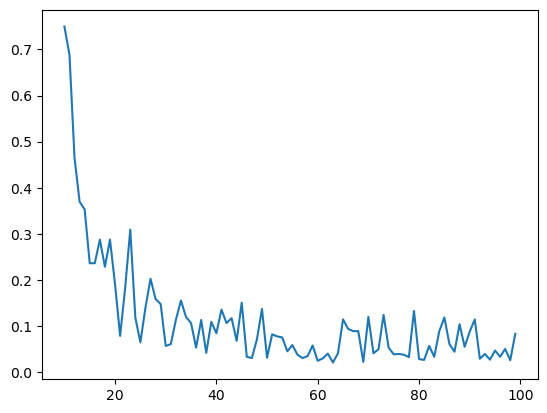

In [5]:
import matplotlib.pyplot as plt
x = [i for i in range(10, 100)]
y = loss[10:]
plt.plot(x, y)
plt.show()

In [6]:
# training with QEM-ZMSEPC method
n_qubits = 2
dev = qml.device('default.mixed', wires=n_qubits, shots=1000)
nqubitschannel = qem.NqubitsChannel(n_qubits)
nqubitspaulichannel = nqubitschannel.nqubitsrandompaulichannel(p_identity=0.85)
p = 0.9
qemzmsepc = qem.QEMZMSEPC(n_qubits)

In [7]:
def train_cir_with_qem(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(2))

def cost(x):
    z_un = qml.QNode(qemzmsepc.noise_circuit, dev)(train_cir_with_qem, parameters=x, p=p,
        kraus_matrices_of_a_pauli_channel=nqubitspaulichannel, need_gate_noise=True, need_measurement_noise=True)
    z_miti, _ = qemzmsepc.qemzmsepc(train_cir_with_qem, z_un, p, dev, x,
            kraus_matrices_of_a_pauli_channel=nqubitspaulichannel)
    return (z_miti - (-1)) ** 2

In [8]:
shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=2)
weights = np.random.random(size=shape)
opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 100
params = weights
loss = []

for i in range(steps):
    nqubitspaulichannel = nqubitschannel.nqubitsrandompaulichannel(p_identity=0.85)
    params = opt.step(cost, params)
    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))
    loss.append(cost(params))
print("Optimized rotation angles: {}".format(params))

Cost after step     5:  2.3183943
It is unstable to do error mitigation in this situation, so the unmitigated value is returned.
It is unstable to do error mitigation in this situation, so the unmitigated value is returned.
Cost after step    10:  0.5018250
Cost after step    15:  0.1633492
Cost after step    20:  0.0321448
Cost after step    25:  0.0141226
Cost after step    30:  0.0019014
Cost after step    35:  0.0214167
Cost after step    40:  0.0009753
Cost after step    45:  0.0041942
Cost after step    50:  0.0023963
Cost after step    55:  0.0121535
Cost after step    60:  0.0031709
Cost after step    65:  0.0023598
Cost after step    70:  0.0121815
Cost after step    75:  0.0000018
Cost after step    80:  0.0013584
Cost after step    85:  0.0081410
Cost after step    90:  0.0085147
Cost after step    95:  0.0071283
Cost after step   100:  0.0008806
Optimized rotation angles: [[[ 0.40116021  0.7558385   0.1149729 ]
  [ 0.42517276  2.77834606 -0.0993228 ]]

 [[ 0.59860713  0.324

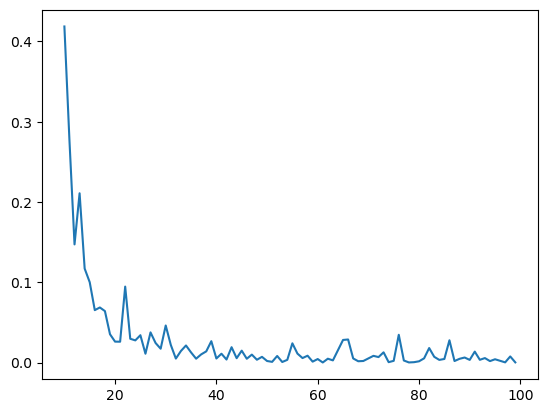

In [9]:
import matplotlib.pyplot as plt
x = [i for i in range(10, 100)]
y = loss[10:]
plt.plot(x, y)
plt.show()